# Tensorflow Records : 

**This notebook focuses on preparing the NIH data subset for TFRecord generation**.


TF record is Tensorflow's binary storage format for your data.

A TFRecord file contains an array of **Examples**. **Example is a data structure for representing a record**, like an observation in a training or test dataset. **A record is represented as a set of features, each of which has a name and can be an array of bytes, floats, or 64-bit integers**.

To summarize :

* An Example contains Features.
* Features is a mapping from the feature names stored as strings to Features.

These relations are defined in *example.proto* and *feature.proto* in the TensorFlow's source code, along with extensive comments. As the extension .proto suggests, these definitions are based on protocol buffers.

## Protocol Buffers : 

Google’s **Protocol buffer is a serialization scheme for structured data**. In other words, protocol buffers are used for serializing structured data into a byte array, so that they can be sent over the network or stored as a file. *In this sense, it is similar to JSON, XML*.

Protocol buffers can offer a lot faster processing speed compared to text-based formats like JSON or XML.

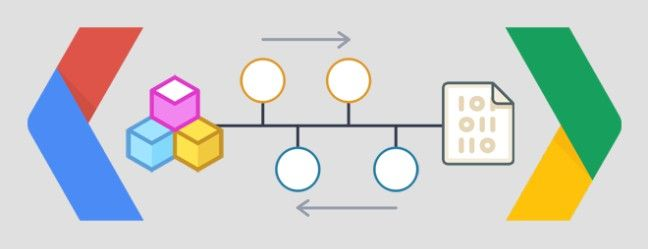

Using protocol buffers has many advantages over plain text serializations like JSON and XML:

* Very dense data which result in very small output and therefore less network overhead
* Declared schema makes parsing from most languages very straightforward with less boilerplate parsing code
* Very fast processing
* Binary encoded and hard to decode without knowledge of the schema

In [1]:
import sys
print(sys.executable)

/media/HHD_2TB/baurai/aditya_vm/bin/python3.6


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import albumentations as A
import tensorflow as tf

print(f"Python version = {sys.version}")
print(f"Numpy version = {np.__version__}")
print(f"OpenCV version = {cv2.__version__}")
print(f"Tensorflow version = {tf.__version__}")

Python version = 3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
Numpy version = 1.18.5
OpenCV version = 4.5.1
Tensorflow version = 2.3.1


In [3]:
df = pd.DataFrame(pd.read_csv("filtered_metadata/metadata.csv"))

print("Shape = ", df.shape)
df.head()

Shape =  (66692, 5)


,image_id,label,patient_id,age,gender
0,00000002_000.png,0,2,80,M
1,00000004_000.png,1,4,82,M
2,00000005_000.png,0,5,69,F
3,00000005_001.png,0,5,69,F
4,00000005_002.png,0,5,69,F


In [4]:
IMAGE_SIZE = (512, 512)

In [5]:
transform = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.Rotate(limit = 45, p = 0.5)
])

In [6]:
def apply_albumin_augmentation(image, transform) : 
    augmented_image = transform(image = image)["image"]
    return augmented_image

# Stratified Sampling : 

Stratified sampling refers to a type of sampling method . With stratified sampling, we divides the population into separate groups, called strata. Then, a simple random sample is drawn from each group.

In [7]:
SIZE = 500

num_of_images = df.shape[0]
image_names = df["image_id"].values

print("Number of images = ", num_of_images)

Number of images =  66692


In [8]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_index, val_cum_test_index in split.split(df, df["label"]) : 
    stratified_train_set = df.loc[train_index]
    stratified_val_cum_test_set = df.loc[val_cum_test_index]

In [9]:
stratified_train_set.reset_index(drop = True, inplace = True)
print("Size of Stratified Training set = ", stratified_train_set.shape)
stratified_train_set.head()

Size of Stratified Training set =  (46684, 5)


,image_id,label,patient_id,age,gender
0,00012907_003.png,0,12907,40,M
1,00014264_002.png,0,14264,64,M
2,00001650_007.png,0,1650,62,M
3,00013894_000.png,1,13894,19,M
4,00017707_001.png,0,17707,25,M


In [10]:
stratified_val_cum_test_set.reset_index(drop = True, inplace = True)
print("Size of Stratified Validation cum Testing set = ", stratified_val_cum_test_set.shape)
stratified_val_cum_test_set.head()

Size of Stratified Validation cum Testing set =  (20008, 5)


,image_id,label,patient_id,age,gender
0,00002524_003.png,0,2524,62,M
1,00001023_002.png,0,1023,51,F
2,00015779_000.png,0,15779,34,F
3,00012051_005.png,0,12051,10,F
4,00020325_000.png,0,20325,53,F


We need to further split stratified_val_cum_test_set into **stratified_validation_set and stratified_test_set**.

In [11]:
split2 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 42)
for val_index, test_index in split2.split(stratified_val_cum_test_set, stratified_val_cum_test_set["label"]) : 
    stratified_val_set = stratified_val_cum_test_set.loc[val_index]
    stratified_test_set = stratified_val_cum_test_set.loc[test_index]

In [12]:
stratified_val_set.reset_index(drop = True, inplace = True)
print("Size of Stratified Validation set = ", stratified_val_set.shape)
stratified_val_set.head()

Size of Stratified Validation set =  (10004, 5)


,image_id,label,patient_id,age,gender
0,00005564_014.png,0,5564,43,F
1,00000488_002.png,0,488,35,F
2,00014792_002.png,1,14792,56,M
3,00014274_008.png,1,14274,34,F
4,00002874_000.png,0,2874,55,M


In [13]:
stratified_test_set.reset_index(drop = True, inplace = True)
print("Size of Stratified Test set = ", stratified_test_set.shape)
stratified_test_set.head()

Size of Stratified Test set =  (10004, 5)


,image_id,label,patient_id,age,gender
0,00008490_001.png,0,8490,58,M
1,00014877_020.png,0,14877,17,M
2,00025686_003.png,0,25686,52,M
3,00007060_016.png,0,7060,49,M
4,00012364_015.png,0,12364,51,F


# Analyze Label Distribution In Stratified Training/Val/Test Set

In [14]:
def analyze_label_distribution(dataframe, case = "train") : 
    """
    Training, validation and testing frames are passed to this method.
    """
    label_count = dict()
    for label in tqdm(dataframe["label"].values) : 
        if label not in label_count : 
            label_count[label] = 1
        else:
            label_count[label] += 1
    labels = ["Healthy Cases", "Nodular Cases"]
    counts = [label_count[0], label_count[1]]
    explode = (0.05, 0.05)
    
    plt.figure(figsize = (20, 12))
    plt.pie(counts, explode = explode, labels = labels, shadow = True, startangle = 90)
    plt.axis("equal")
    
    print("Healthy cases count = ", label_count[0])
    print("Nodular cases count = ", label_count[1])

  0%|          | 0/46684 [00:00<?, ?it/s]

Healthy cases count =  42252
Nodular cases count =  4432


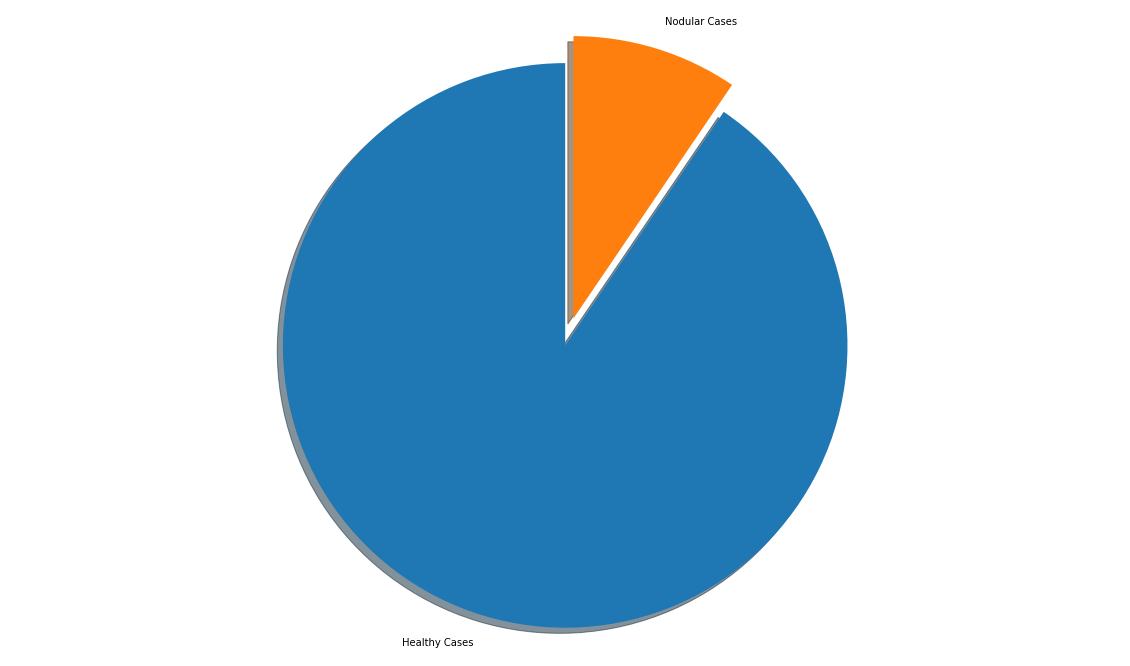

In [15]:
analyze_label_distribution(stratified_train_set)

  0%|          | 0/10004 [00:00<?, ?it/s]

Healthy cases count =  9054
Nodular cases count =  950


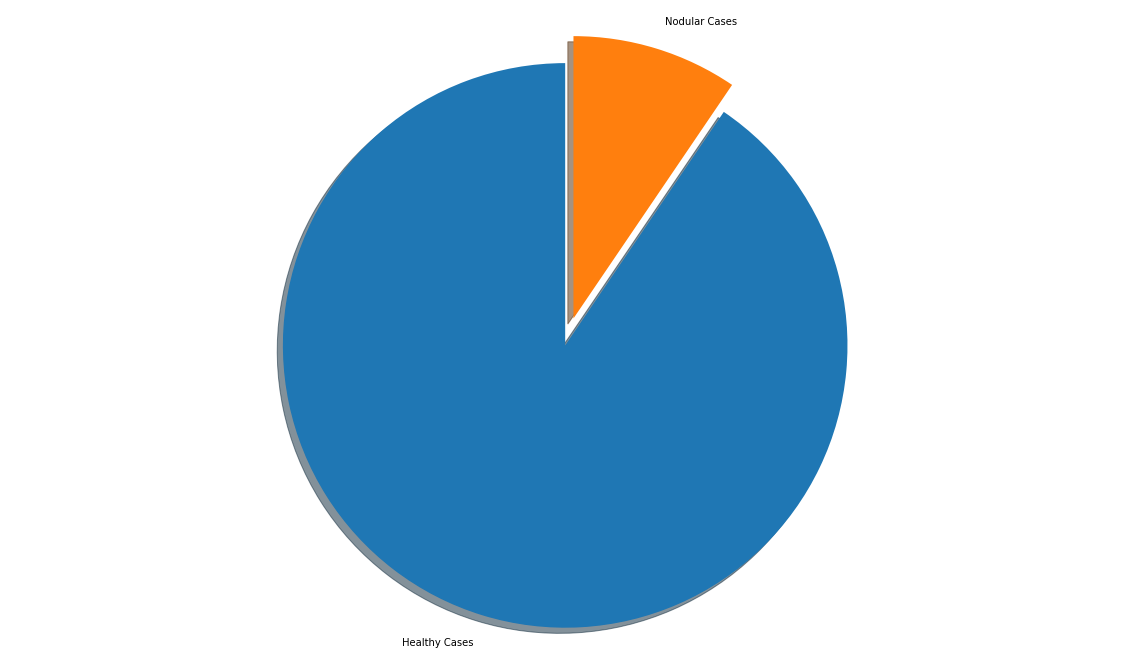

In [16]:
analyze_label_distribution(stratified_val_set)

  0%|          | 0/10004 [00:00<?, ?it/s]

Healthy cases count =  9055
Nodular cases count =  949


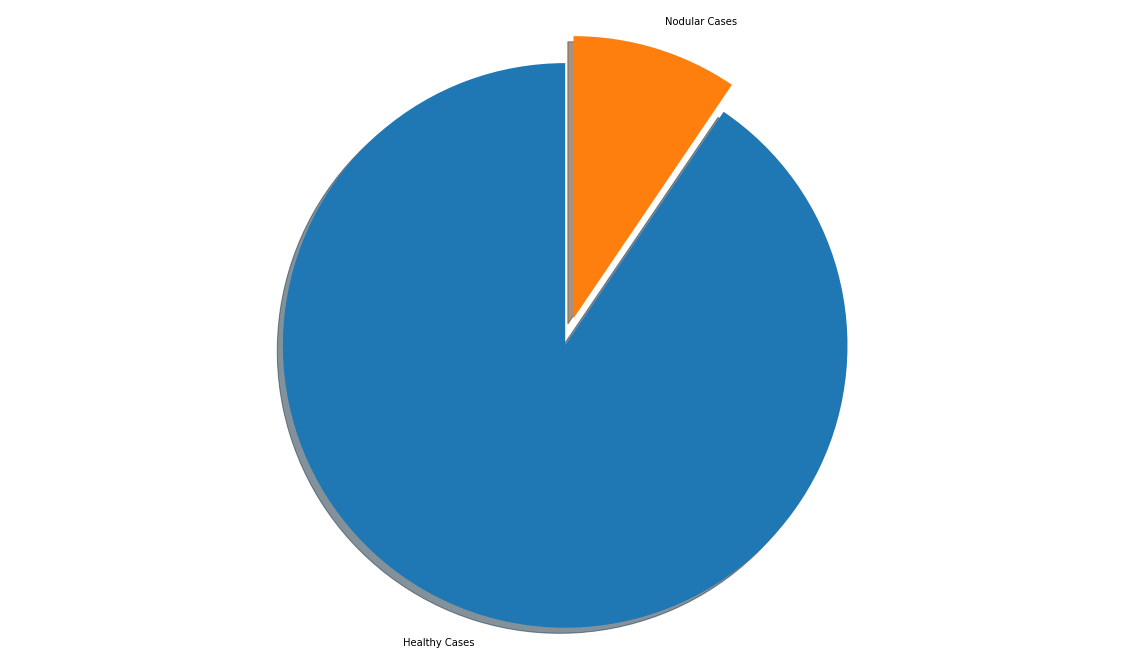

In [17]:
analyze_label_distribution(stratified_test_set)

Stratified sampling successful!

# TFRec Preparation

We will also create a metadata file to store all the new info, as we will be expanding the dataset post augmentation too.

Columns : [image_name, label, subset] 
* subset will store whether the image is for training/val/testing.

In [18]:
metadata_bin_clf_tfrec = pd.DataFrame(columns = ["image_name", "label", "subset"])

metadata_bin_clf_tfrec

,image_name,label,subset


In [19]:
training_image_ids = stratified_train_set["image_id"].values
validation_image_ids = stratified_val_set["image_id"].values
testing_image_ids = stratified_test_set["image_id"].values

print(f"{len(training_image_ids)} training, {len(validation_image_ids)} validation and {len(testing_image_ids)} testing images located!")

46684 training, 10004 validation and 10004 testing images located!


In [20]:
PATH = "/media/HHD2/NIH/tflow_obj_detection/images/"

## Training TFRec Files : 

In [21]:
def bytes_features(value) : 
    if isinstance(value, type(tf.constant(0))) : 
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def float_features(value) : 
    return tf.train.Feature(float_list = tf.train.FloatList(value = [value]))

def int64_features(value) : 
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

A TFRecord files is a tensor of records, which are represented using Example data structure. **This data structure is nothing more than a compilation of faetures which map the OG string features to TF compatible feature format**.

This is what we are gonna do now. We define a set of features and encapsulate them in an Example data structure.

In [22]:
def serialize_example(feature_list) : 
    # feature_list = [image, image_name, label]
    feature = {
        "image" : bytes_features(feature_list[0]),
        "image_name" : bytes_features(feature_list[1]),
        "label" : int64_features(feature_list[2])
    }
    example_proto = tf.train.Example(features = tf.train.Features(feature = feature))
    return example_proto.SerializeToString()

In [23]:
total_chunks = len(training_image_ids)//SIZE + int(len(training_image_ids)%SIZE != 0)

print("Total training record to be prepared = ", total_chunks)

Total training record to be prepared =  94


In [24]:
dataframe_index = 0 # for appending entry to the meta dataframe

In [25]:
count_healthy = 0 
for j in tqdm(range(total_chunks)) : 
    print("\nWriting Training TFRecord %i of %i"%(j+1, total_chunks))
    count = min(SIZE, len(training_image_ids) - (j * SIZE))
    with tf.io.TFRecordWriter("./tfrec_v3/train%.2i.tfrec"%(j)) as writer : 
        c = 0 
        for k in range(count) : 
            image_id = training_image_ids[(SIZE * j) + k]
            image_path = PATH + image_id
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE[0], IMAGE_SIZE[0]), interpolation = cv2.INTER_NEAREST)
            
            
            if stratified_train_set.loc[stratified_train_set.image_id == image_id].values[0][1] == 1 :
                t = 0 
                for t in range(2) : 
                    image_copy = image.copy()
                    image_copy = apply_albumin_augmentation(image_copy, transform)
                    image_copy = cv2.imencode(".jpg", image_copy, (cv2.IMWRITE_JPEG_QUALITY, 95))[1].tostring()
                    name_with_extension = image_id
                    name_without_extension = name_with_extension.split(".")[0] + "_" + str(t)
                    row = stratified_train_set.loc[stratified_train_set.image_id == name_with_extension]
                    feature_list = [image_copy, str.encode(name_without_extension), row.label.values[0]]
                    example = serialize_example(feature_list)
                    writer.write(example)
                    
                    metadata_bin_clf_tfrec.loc[dataframe_index] = [name_without_extension + ".png", row.label.values[0], "training"]
                    dataframe_index = dataframe_index + 1
                    
                    c += 1
                    
                    if c %100 == 0 :
                        print(c, ",", end = " ")
            else:
                count_healthy = count_healthy + 1
                if count_healthy % 2 == 0 : 
                    image = cv2.imencode(".jpg", image, (cv2.IMWRITE_JPEG_QUALITY, 95))[1].tostring()
                    name_with_extension = image_id
                    name_without_extension = name_with_extension.split(".")[0]
                    row = stratified_train_set.loc[stratified_train_set.image_id == name_with_extension]
                    feature_list = [image, str.encode(name_without_extension), row.label.values[0]]
                    example = serialize_example(feature_list)
                    writer.write(example)
                
                    metadata_bin_clf_tfrec.loc[dataframe_index] = [name_without_extension + ".png", row.label.values[0], "training"]
                    dataframe_index = dataframe_index + 1
                    
                    c += 1
                
                    if c %100 == 0 :
                        print(c, ",", end = " ")
            

  0%|          | 0/94 [00:00<?, ?it/s]


Writing Training TFRecord 1 of 94
100 , 200 , 300 , 
Writing Training TFRecord 2 of 94
100 , 200 , 300 , 
Writing Training TFRecord 3 of 94
100 , 200 , 300 , 
Writing Training TFRecord 4 of 94
100 , 200 , 300 , 
Writing Training TFRecord 5 of 94
100 , 200 , 300 , 
Writing Training TFRecord 6 of 94
100 , 200 , 300 , 
Writing Training TFRecord 7 of 94
100 , 200 , 300 , 
Writing Training TFRecord 8 of 94
100 , 200 , 300 , 
Writing Training TFRecord 9 of 94
100 , 200 , 300 , 
Writing Training TFRecord 10 of 94
100 , 200 , 300 , 
Writing Training TFRecord 11 of 94
100 , 200 , 300 , 
Writing Training TFRecord 12 of 94
100 , 200 , 300 , 
Writing Training TFRecord 13 of 94
100 , 200 , 300 , 
Writing Training TFRecord 14 of 94
100 , 200 , 300 , 
Writing Training TFRecord 15 of 94
100 , 200 , 300 , 
Writing Training TFRecord 16 of 94
100 , 200 , 300 , 
Writing Training TFRecord 17 of 94
100 , 200 , 300 , 
Writing Training TFRecord 18 of 94
100 , 200 , 300 , 
Writing Training TFRecord 19 of 94
1

In [26]:
metadata_bin_clf_tfrec.head()

,image_name,label,subset
0,00014264_002.png,0,training
1,00013894_000_0.png,1,training
2,00013894_000_1.png,1,training
3,00017707_001.png,0,training
4,00014052_006.png,0,training


In [27]:
metadata_bin_clf_tfrec.shape

(29990, 3)

## Validation TFRec Files : 

In [28]:
total_chunks = len(validation_image_ids)//SIZE + int(len(validation_image_ids)%SIZE != 0)

print("Total training record to be prepared = ", total_chunks)

Total training record to be prepared =  21


In [29]:
for j in tqdm(range(total_chunks)) : 
    print("\nWriting Validation TFRecord %i of %i"%(j+1, total_chunks))
    count = min(SIZE, len(validation_image_ids) - (j * SIZE))
    with tf.io.TFRecordWriter("./tfrec_v3/val%.2i.tfrec"%(j)) as writer : 
        c = 0 
        for k in range(count) : 
            image_id = validation_image_ids[(SIZE * j) + k]
            image = cv2.imread(PATH + image_id)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE[0], IMAGE_SIZE[0]), interpolation = cv2.INTER_NEAREST)
            image = cv2.imencode(".jpg", image, (cv2.IMWRITE_JPEG_QUALITY, 95))[1].tostring()
            name_with_extension = image_id
            name_without_extension = name_with_extension.split(".")[0]
            row = stratified_val_set.loc[stratified_val_set.image_id == name_with_extension]
            feature_list = [image, str.encode(name_without_extension), row.label.values[0]]
            example = serialize_example(feature_list)
            writer.write(example)
                
            metadata_bin_clf_tfrec.loc[dataframe_index] = [name_without_extension + ".png", row.label.values[0], "validation"]
            dataframe_index = dataframe_index + 1
                
            c += 1
                
            if c %100 == 0 :
                print(c, ",", end = " ")

  0%|          | 0/21 [00:00<?, ?it/s]


Writing Validation TFRecord 1 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 2 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 3 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 4 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 5 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 6 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 7 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 8 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 9 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 10 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 11 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 12 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 13 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 14 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Validation TFRecord 15 of 21
100 , 200 , 300 , 4

In [30]:
metadata_bin_clf_tfrec.head()

,image_name,label,subset
0,00014264_002.png,0,training
1,00013894_000_0.png,1,training
2,00013894_000_1.png,1,training
3,00017707_001.png,0,training
4,00014052_006.png,0,training


In [31]:
metadata_bin_clf_tfrec.shape

(39994, 3)

## Test TFRec Files : 

In [32]:
total_chunks = len(testing_image_ids)//SIZE + int(len(testing_image_ids)%SIZE != 0)

print("Total training record to be prepared = ", total_chunks)

Total training record to be prepared =  21


In [33]:
for j in tqdm(range(total_chunks)) : 
    print("\nWriting Testing TFRecord %i of %i"%(j+1, total_chunks))
    count = min(SIZE, len(testing_image_ids) - (j * SIZE))
    with tf.io.TFRecordWriter("./tfrec_v3/test%.2i.tfrec"%(j)) as writer : 
        c = 0 
        for k in range(count) : 
            image_id = testing_image_ids[(SIZE * j) + k]
            image = cv2.imread(PATH + image_id)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE[0], IMAGE_SIZE[0]), interpolation = cv2.INTER_NEAREST)
            image = cv2.imencode(".jpg", image, (cv2.IMWRITE_JPEG_QUALITY, 95))[1].tostring()
            name_with_extension = image_id
            name_without_extension = name_with_extension.split(".")[0]
            row = stratified_test_set.loc[stratified_test_set.image_id == name_with_extension]
            feature_list = [image, str.encode(name_without_extension), row.label.values[0]]
            example = serialize_example(feature_list)
            writer.write(example)
                
            metadata_bin_clf_tfrec.loc[dataframe_index] = [name_without_extension + ".png", row.label.values[0], "testing"]
            dataframe_index = dataframe_index + 1    
                
            c += 1
                
            if c %100 == 0 :
                print(c, ",", end = " ")

  0%|          | 0/21 [00:00<?, ?it/s]


Writing Testing TFRecord 1 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 2 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 3 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 4 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 5 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 6 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 7 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 8 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 9 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 10 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 11 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 12 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 13 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 14 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 15 of 21
100 , 200 , 300 , 400 , 500 , 
Writing Testing TFRecord 16 of 21

In [34]:
metadata_bin_clf_tfrec.head()

,image_name,label,subset
0,00014264_002.png,0,training
1,00013894_000_0.png,1,training
2,00013894_000_1.png,1,training
3,00017707_001.png,0,training
4,00014052_006.png,0,training


In [35]:
metadata_bin_clf_tfrec.shape

(49998, 3)

In [37]:
metadata_bin_clf_tfrec.to_csv(r"tfrec_v3/metadata_bin_clf_tfrec.csv", index = False)